# A Quick Demo of Andrej Karpathy's minGPT Play Char Demo 

**Our Goal**: Generate Shakesperean text
- You can find the original Play Char demo in the minGPT repo here: https://github.com/karpathy/minGPT
- This notebook is partially based on the fastai Transformers tutorial: http://docs.fast.ai/tutorial.transformers

In [1]:
# For Colab
# !pip install fastai --upgrade
# !git clone https://github.com/karpathy/minGPT
# !pip install snakeviz

In [2]:
from fastai.text.all import *
from minGPT.mingpt.model import GPT, GPTConfig, GPT1Config

Download the raw text file

In [3]:
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

Read it in

In [4]:
raw_text = open('input.txt', 'r').read()
raw_text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

## Data Loaders

We re-implement Karpathy's `CharDataset` as a fastai Transform, which will then be passed to a dataloader

In [5]:
class CharTransform(DisplayedTransform):
    def __init__(self, data, block_size):
        self.cat = Categorize()
        self.block_size = block_size + 1
        self.data = data
        
    def setups(self, items=None):
        self.data_len = len(self.data)
        self.cat.setup(L(*self.data))
        self.itos = self.cat.vocab
        self.stoi = self.itos.items.val2idx()
        print(f'data has {self.data_len} characters, {len(self.itos)} unique.')
        self.n_sequences = math.ceil(self.data_len / (self.block_size))
        self.idxs = L(np.random.randint(0, self.data_len - (self.block_size), self.n_sequences).tolist())

    def encodes(self, o):
        chunk = self.data[self.idxs[o]:self.idxs[o]+self.block_size]
        return tensor([self.stoi[s] for s in chunk])

    def decodes(self, o): return TitledStr(''.join([self.itos[s.item()] for s in o]))

We define out block_size and n_samples (which is the number of batches in a single epoch)

**Note**:
- Note `block_size` in Karpathy's code is equivalent to `Sequence Length` in fastai
- We do not specify a validation set here as Karpathy does not in their notebook. Therefore we set `split_idx=0` in `TfmdLists`

In [6]:
block_size=128
n_sequences = math.ceil(len(raw_text) / (block_size+1)); n_sequences

8647

And we test our transform quickly

In [7]:
t = CharTransform(data=raw_text, block_size=block_size)
t.setups()

data has 1115394 characters, 65 unique.


Now we add our Transform to a `Dataset`, read more about fastai's `Dataset` [here](https://docs.fast.ai/data.core#Datasets)

In [8]:
dset = Datasets(L(range(n_sequences)), tfms=[CharTransform(raw_text, block_size)], dl_type=LMDataLoader)

data has 1115394 characters, 65 unique.


We will use an `LMDataLoader` since we have a language modeling problem, meaning it is designed to be used when trying to predict the next character/token.

Lets have a look at the first item in our dataset

In [9]:
dset[0]

(tensor([53, 58, 46,  1, 46, 43, 11,  0, 13, 52, 42,  6,  1, 54, 56, 43, 58, 58,
         63,  1, 44, 53, 53, 50,  6,  1, 47, 58,  1, 57, 58, 47, 52, 58, 43, 42,
          1, 39, 52, 42,  1, 57, 39, 47, 42,  1,  5, 13, 63,  8,  5,  0,  0, 24,
         13, 16, 37,  1, 15, 13, 28, 33, 24, 17, 32, 10,  0, 17, 52, 53, 59, 45,
         46,  1, 53, 44,  1, 58, 46, 47, 57, 11,  1, 21,  1, 54, 56, 39, 63,  1,
         58, 46, 43, 43,  6,  1, 46, 53, 50, 42,  1, 58, 46, 63,  1, 54, 43, 39,
         41, 43,  8,  0,  0, 26, 59, 56, 57, 43, 10,  0, 37, 43, 57,  6,  1, 51,
         39, 42, 39]),)

And what the original text for this first item was:

In [10]:
show_at(dset.train, 0)

oth he;
And, pretty fool, it stinted and said 'Ay.'

LADY CAPULET:
Enough of this; I pray thee, hold thy peace.

Nurse:
Yes, mada


The fastai library expects the data to be assembled in a `DataLoaders` object (something that has a training and validation dataloader). We can get one by using the `dataloaders` method. We just have to specify a batch size and a sequence length. 

To further optimize the `LMDataLoader` initialisation, we pass a list of item lengths. As each item is already `block_size + 1` digits long we don't need to re-calculate the actual length for each item.

In [11]:
bs = 256
lens = [block_size+1 for i in range(len(dset.train))]
dls = dset.dataloaders(bs=bs, seq_len=block_size, lens=lens)

We can inspect a single batch by uncommenting the below line:

In [12]:
#o = dls.one_batch(); len(o), o[0].size(), o[1].size(), o

And we can also inspect what a single batch looks like

In [13]:
dls.show_batch(max_n=2)

,text,text_
0,"to't.\n\nISABELLA:\nThis gentleman told somewhat of my tale,--\n\nLUCIO:\nRight.\n\nDUKE VINCENTIO:\nIt may be right; but you are i' the","o't.\n\nISABELLA:\nThis gentleman told somewhat of my tale,--\n\nLUCIO:\nRight.\n\nDUKE VINCENTIO:\nIt may be right; but you are i' the w"
1,ou meddle with my master?\n\nCOmost likely 'tis for you:\nConsider of it.'\n\nFirst Senator:\nOur army's in the field\nWe never yet mad,u meddle with my master?\n\nCOmost likely 'tis for you:\nConsider of it.'\n\nFirst Senator:\nOur army's in the field\nWe never yet made


## Callback to Grab First Output

We only need the logits from the model, however Karpathy's GPT model actually also calculates and returns the loss in the forward pass, `(logits, loss)`.  So we need to write the event `after_pred` and replace `self.learn.pred` (which contains the predictions that will be passed to the loss function) by just its first element. 

In [14]:
class DropLoss(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

## GPT Model

I had to use 6 layers instead of 8 as my 2080 GPU has 13GB of ram

In [15]:
mconf = GPTConfig(vocab_size=len(dls.itos), block_size=block_size, n_layer=6, n_head=8, n_embd=512)
model = GPT(mconf)

## Learner

We pass our dataloader and model to a `Learner` and adjust the Adam's hyperparameters to match Karpathy's. We'll use `to_native_fp16` to use [PyTorch's automatic mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html)

In [16]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                opt_func=partial(Adam, sqr_mom=0.95, wd=0.1), cbs=[DropLoss]).to_native_fp16()

Start a training loop

*(Scroll past learner output to see an example of the output text the model can generate)*

/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.14454397559165955)

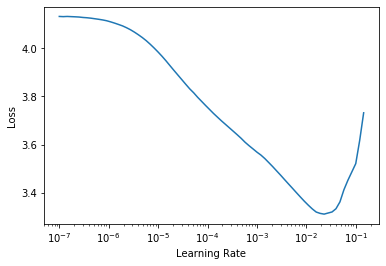

In [17]:
learn.lr_find()

In [18]:
# FP16 NATIVE
learn.fit_one_cycle(100, 6e-4, div_final=10)    

epoch,train_loss,valid_loss,time
0,3.317739,None,00:11
1,3.033413,None,00:11
2,2.807518,None,00:11
3,2.665807,None,00:11
4,2.572921,None,00:11
5,2.509148,None,00:11
6,2.463208,None,00:11
7,2.428268,None,00:11
8,2.394268,None,00:11
9,2.353075,None,00:11


/home/morgan/anaconda3/envs/fastai2_me/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


Note there is no validation loss or validation perplexity as we we didn't specify a validation set (as per Karpathy's notebook)

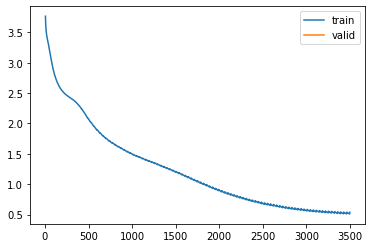

In [22]:
learn.recorder.plot_loss()

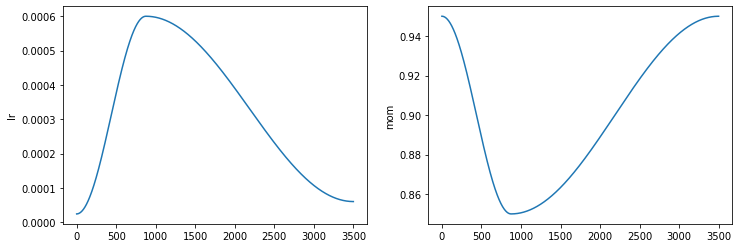

In [23]:
learn.recorder.plot_sched()

And now lets generate some Shakespeare!

In [19]:
from minGPT.mingpt.utils import sample

context = "O God, O God!"
x = torch.tensor([dls.char_transform.stoi[s] for s in context], dtype=torch.long)[None,...].to(dls.device)
y = sample(model, x, 2000, temperature=0.9, sample=True, top_k=5)[0]
completion = ''.join([dls.char_transform.itos[int(i)] for i in y])
print(completion)

O God, O God! if my deping  power.

RIVERS:
Come, Grey, come, Vaughan, let us all embrace:
A to the beastless dearth
That ever enter'd in a drowsy head,
Have I lu die with my lords o' the field? sweet flower now,
Lest that thy love prove likewise variable.

ROMEO:
What shall I swear by? I long as I shall shake, them thus:
Give me some breath, some little pause, my lord
Before I positively herein:
I will resolve your grace immediately.

CATESBY:

KING RICHARD III:
Should dying men flatter with those that live?

JOHN OF GAUNT:
What, talking with a priest, lord chamberlain?
Your friends at Pomfret, they do need the priest;
You must hear me, are you mad?

POMPEY:
Proof?

ABHORSON:
Every true: all the lord protector of the king,
With powerful policy strengthen themselves,
And trust not simple Henry nor his oaths.

MONTAGUE:
Brother, I go; I'll win it out of doors.

ANGELO:
Now, what's the matter. Provost?

Provost:
Is it your will Claudio?

ISABELLA:
I am a woeful suitor to your honour!

LU